# Window - 2020 January 06

In [1]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.dataset import OzeDataset
from tst.loss import OZELoss
from tst.utils import visual_sample, compute_loss

In [2]:
# Training parameters
DATASET_PATH = 'datasets/dataset_CAPTrocadero_v5.npz'
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 2e-4
EPOCHS = 40

# Model parameters
d_model = 48 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 4 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = "window"

d_input = 39 # From dataset
d_output = 8 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


## Training

### Load dataset

In [3]:
ozeDataset = OzeDataset(DATASET_PATH)

dataset_train, dataset_val, dataset_test = random_split(ozeDataset, (12000, 500, 500))

dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=False
                             )

dataloader_val = DataLoader(dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS
                           )

dataloader_test = DataLoader(dataset_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS
                            )

### Load network

In [4]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, N, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = OZELoss(alpha=0.3)

### Train

[Epoch  40/40]: 100%|██████████| 12000/12000 [06:33<00:00, 30.47it/s, loss=0.000288, val_loss=0.000264]


model exported to models/model_2020_01_06__144203.pth with loss 0.000264


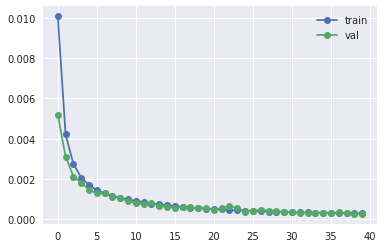

In [5]:
model_save_path = f'models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

## Validation

In [6]:
_ = net.eval()

### Plot results on a sample

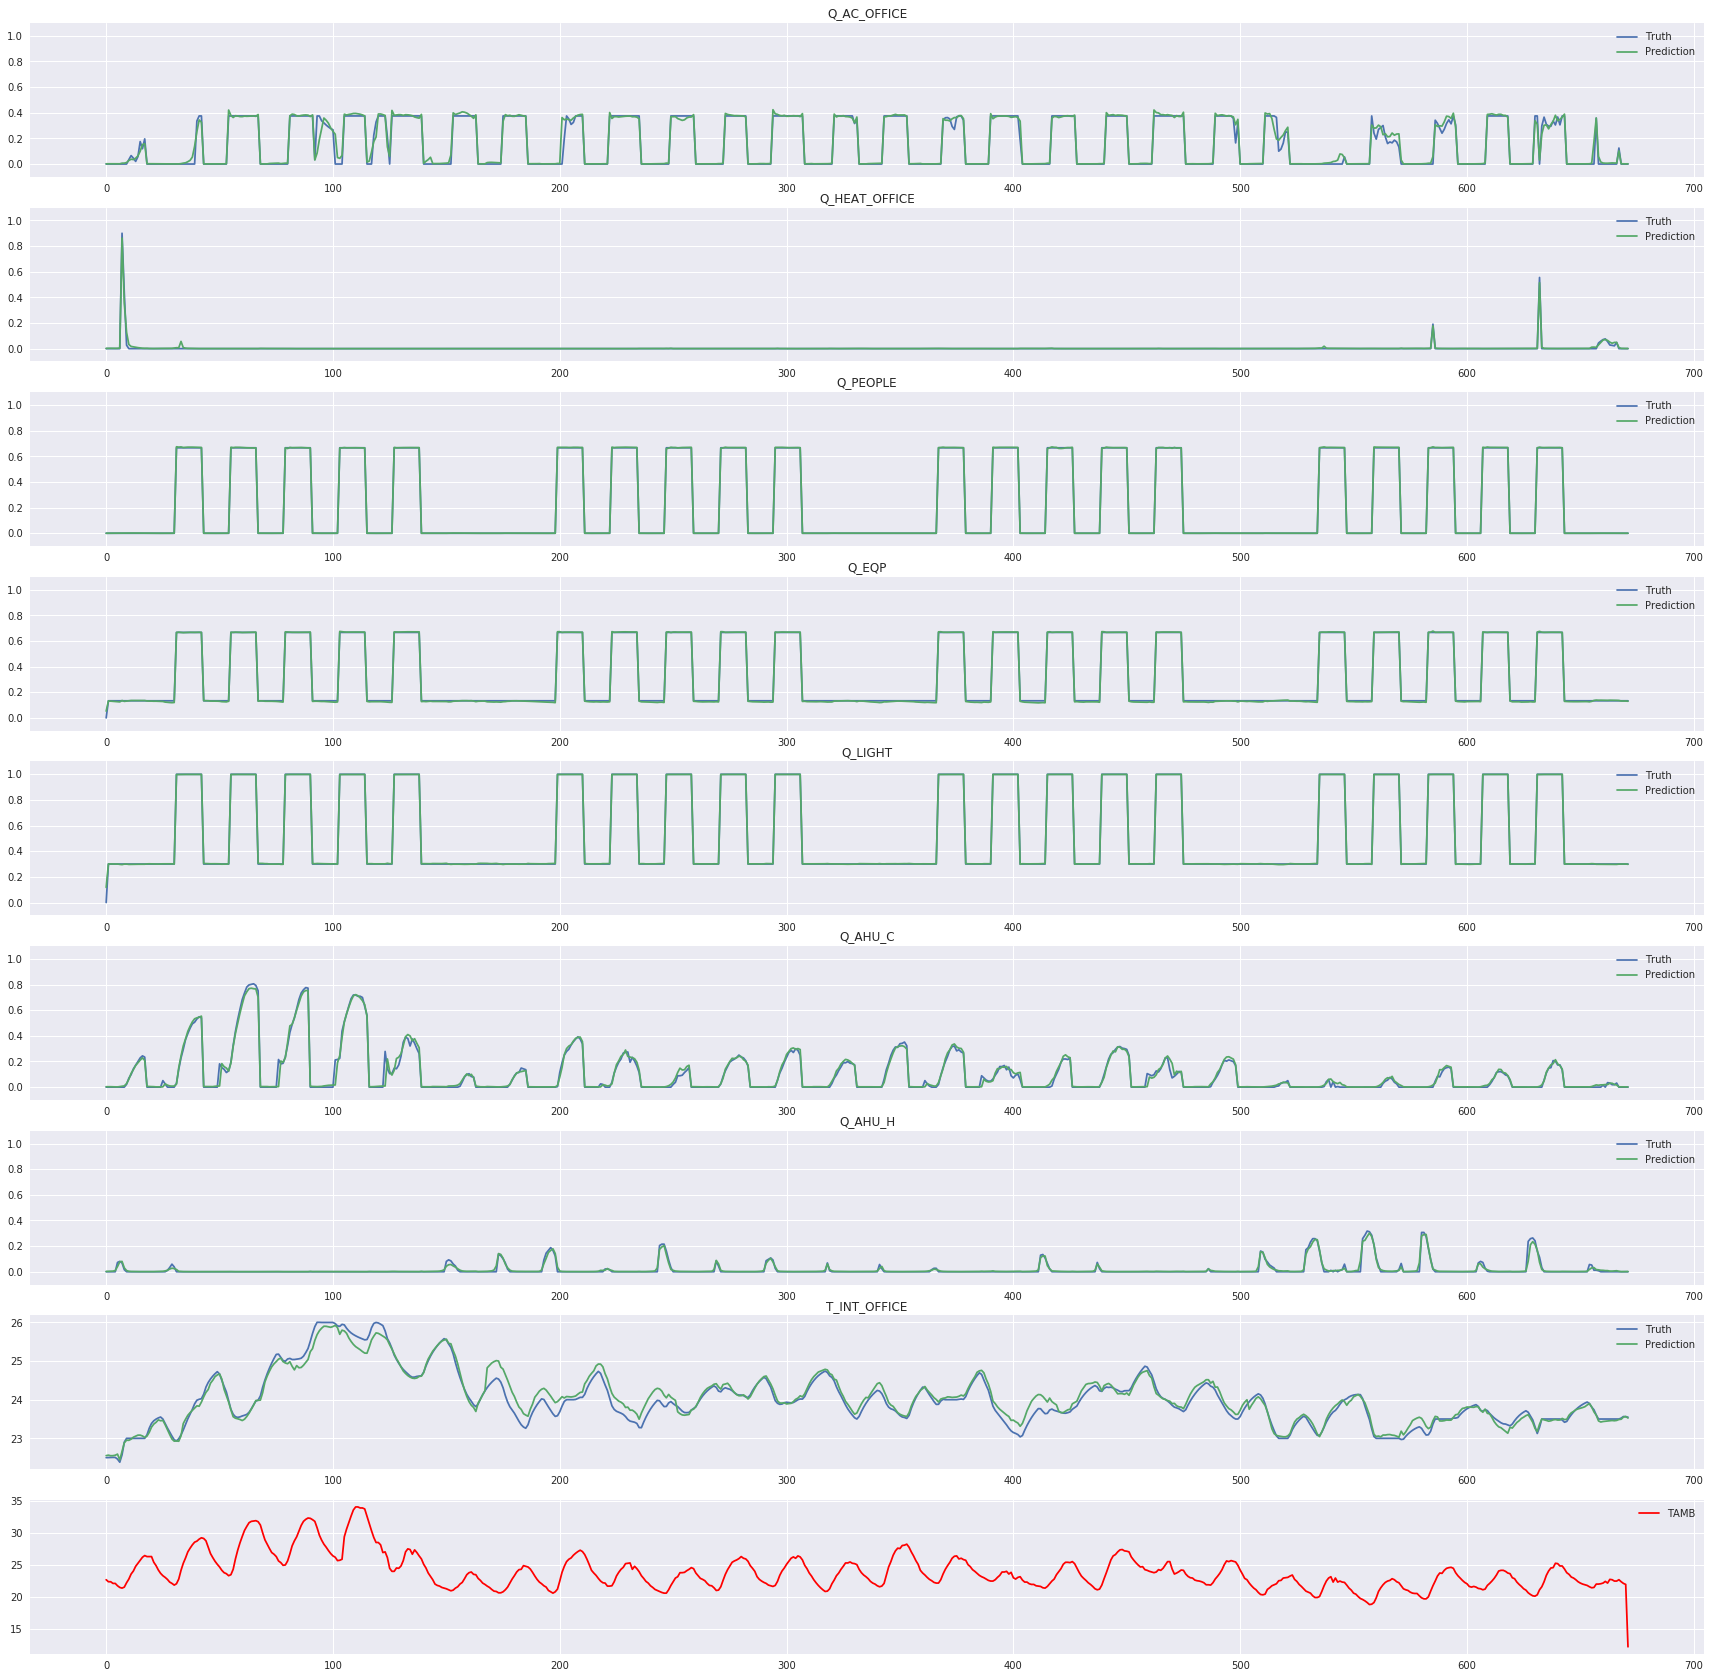

In [7]:
visual_sample(dataloader_test, net, device)
plt.savefig("fig.jpg")

### Plot encoding attention map

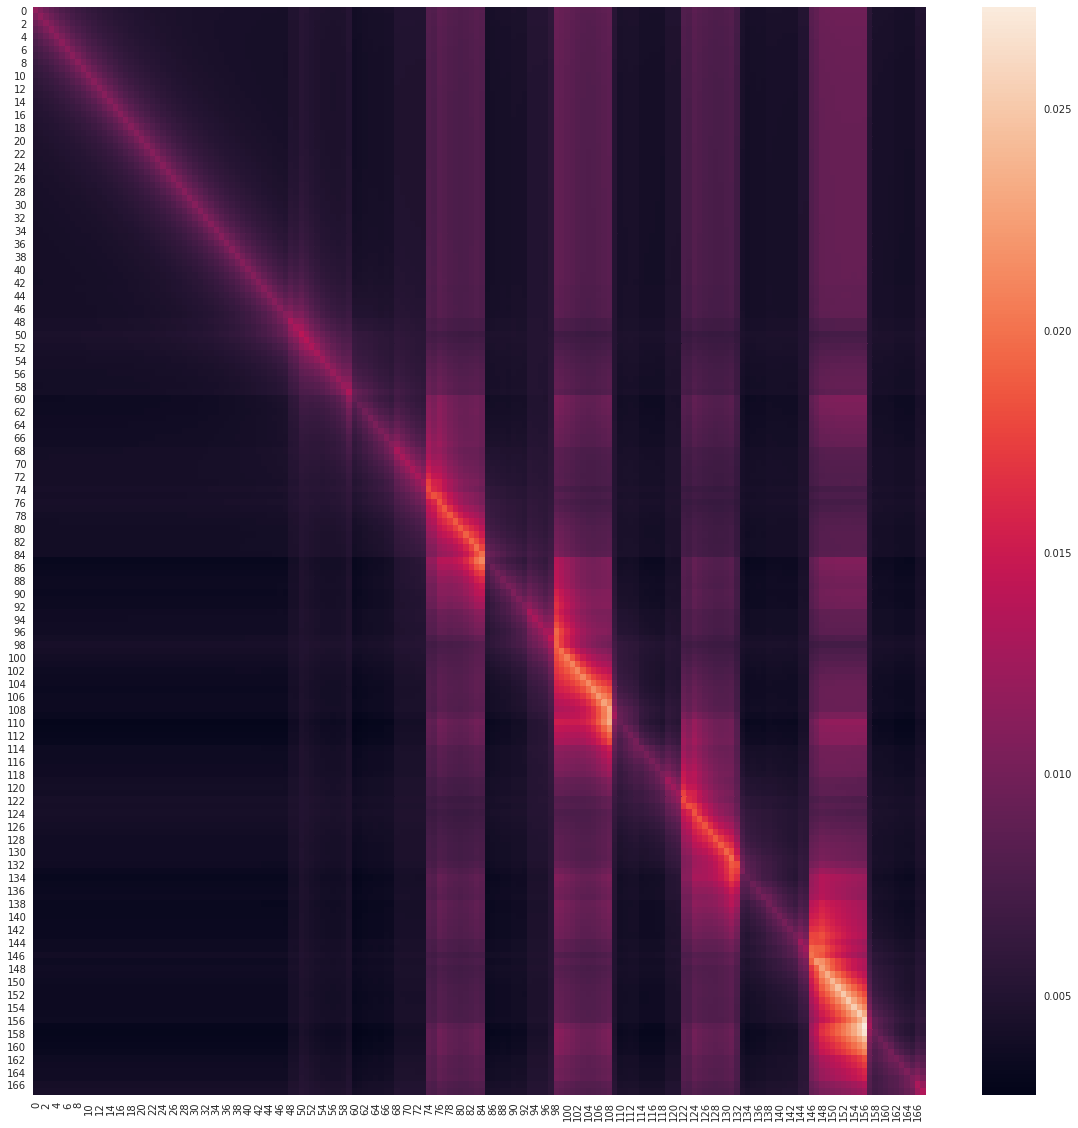

In [8]:
# Select first encoding layer
encoder = net.layers_encoding[0]

# Get the first attention map
attn_map = encoder.attention_map[0].cpu()

# Plot
plt.figure(figsize=(20, 20))
sns.heatmap(attn_map)
plt.savefig("attention_map.jpg")

### Evaluate on the test dataset

In [9]:
predictions = np.empty(shape=(len(dataloader_test.dataset), 672, 8))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|██████████| 125/125 [00:06<00:00, 19.63it/s]


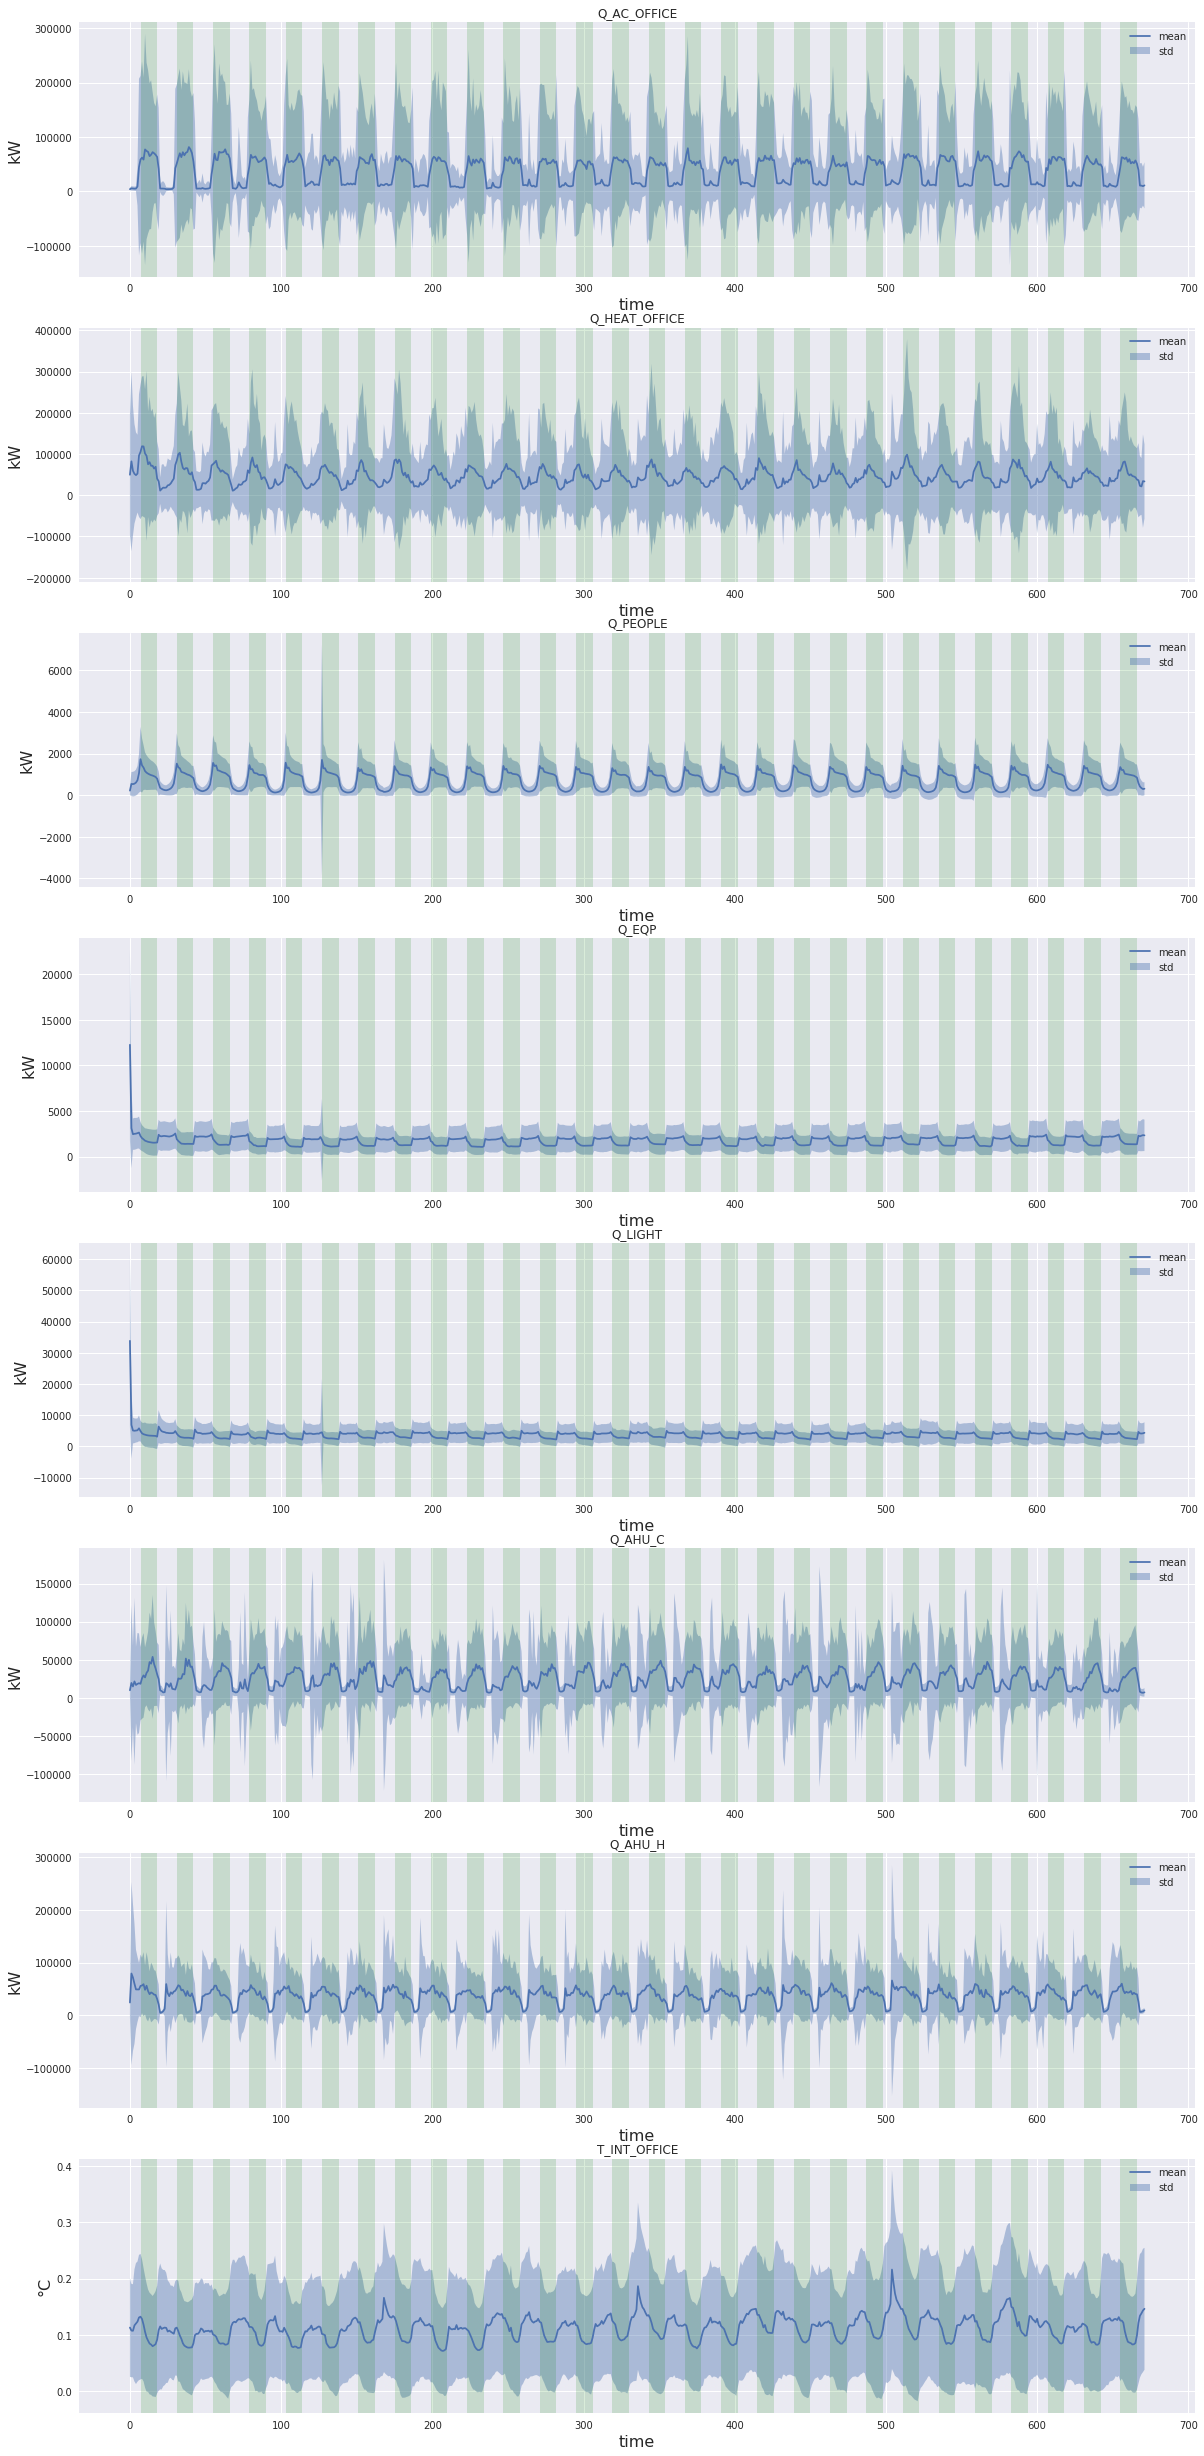

In [10]:
fig, axes = plt.subplots(8, 1)
fig.set_figwidth(20)
fig.set_figheight(40)
plt.subplots_adjust(bottom=0.05)

occupancy = (dataloader_test.dataset.dataset._x.numpy()[..., dataloader_test.dataset.dataset.labels["Z"].index("occupancy")].mean(axis=0)>0.5).astype(float)
y_true_full = dataloader_test.dataset.dataset._y[dataloader_test.dataset.indices].numpy()
                                                 
for idx_label, (label, ax) in enumerate(zip(dataloader_test.dataset.dataset.labels['X'], axes)):
    # Select output to plot
    y_true = y_true_full[..., idx_label]
    y_pred = predictions[..., idx_label]
    
    # Rescale
    y_true = dataloader_test.dataset.dataset.rescale(y_true, idx_label)
    y_pred = dataloader_test.dataset.dataset.rescale(y_pred, idx_label)
    
    # Compute delta, mean and std
    delta = np.abs(y_true - y_pred)
    
    mean = delta.mean(axis=0)
    std = delta.std(axis=0)
    
    # Plot
    # Labels for consumption and temperature
    if label.startswith('Q_'):
        y_label_unit = 'kW'
    else:
        y_label_unit = '°C'
    
    # Occupancy
    occupancy_idxes = np.where(np.diff(occupancy) != 0)[0]
    for idx in range(0, len(occupancy_idxes), 2):
        ax.axvspan(occupancy_idxes[idx], occupancy_idxes[idx+1], facecolor='green', alpha=.15)
    
    # Std
    ax.fill_between(np.arange(mean.shape[0]), (mean - std), (mean + std), alpha=.4, label='std')
    
    # Mean
    ax.plot(mean, label='mean')
    
    # Title and labels
    ax.set_title(label)
    ax.set_xlabel('time', fontsize=16)
    ax.set_ylabel(y_label_unit, fontsize=16)
    ax.legend()
    
plt.savefig('error_mean_std.jpg')